In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report



In [ ]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.5 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4305 sha256=ca4424e3a1f1a53e98df0ae486a656f6b0b1186375018f167c99ee38446485a0
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [ ]:
import pandas as pd
import py_vncorenlp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

###### Dùng công cụ VnCoreNLP để tách từ

In [ ]:
import os
save_dir = '/content/drive/MyDrive/Text_Classification/vncorenlp'

model_path = os.path.join(save_dir, 'VnCoreNLP-1.2.jar')
if not os.path.exists(model_path):
    print("Downloading VnCoreNLP model...")

    if not os.path.exists('/content/drive'):
      from google.colab import drive
      drive.mount('/content/drive')

       if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    py_vncorenlp.download_model(save_dir=save_dir)
    print("Finish")
else:
    print("VnCoreNLP model already exists.")

In [ ]:
save_dir = '/content/drive/MyDrive/Text_Classification/vncorenlp'
vncorenlp_model = py_vncorenlp.VnCoreNLP(
      annotators=["wseg"],
      save_dir=save_dir
  )

###### Xử lý dữ liệu đầu vào

[Link nguồn của tập dữ liệu ](https://github.com/hoadm-net/VNews8td)

In [ ]:

train_df = pd.read_csv('/content/drive/MyDrive/Text_Classification/train.tsv',sep = '\t',header = None,names = ['text', 'label'])
test_df = pd.read_csv('/content/drive/MyDrive/Text_Classification/test.tsv',sep = '\t',header = None,names = ['text', 'label'])
val_df = pd.read_csv('/content/drive/MyDrive/Text_Classification/val.tsv',sep = '\t',header = None,names = ['text', 'label'])


In [ ]:
from string import punctuation
def clean_text(input_str) -> str:
  my_punctuation = punctuation.replace('_', '')
  output_str = vncorenlp_model.word_segment(input_str)
  output = ' '.join(output_str)#nối các từ đã phân đoạn lại
  output_str = output.translate(str.maketrans('', '', my_punctuation))#bỏ dấu câu
  output_str = ' '.join(output_str.split())# bỏ khoảng trắng
  return output_str.lower()#viết thường

In [ ]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)


In [ ]:

train_df.head(20)

,text,label,clean_text
0,Ba Lan sa thải HLV Santos sau sáu trận. Liên đ...,thethao,ba_lan sa_thải hlv santos sau sáu trận liên_đo...
1,Trữ trứng để sinh con được bao lâu?. Tôi 32 tu...,suckhoe,trữ trứng để sinh con được bao_lâu tôi 32 tuổi...
2,Thường xuyên đau lưng là bệnh gì?. Lưng vợ tôi...,suckhoe,thường_xuyên đau lưng là bệnh gì lưng vợ tôi t...
3,Người mẹ bỏ chữa ung thư để tìm sự sống cho co...,doisong,người mẹ bỏ chữa ung_thư để tìm sự sống cho co...
4,"Nguy cơ Covid đồng nhiễm virus, vi khuẩn gây b...",suckhoe,nguy_cơ covid đồng nhiễm virus vi_khuẩn gây bệ...
5,Chênh lệch 3 điểm giữa thí sinh đỗ bằng học bạ...,giaoduc,chênh_lệch 3 điểm giữa thí_sinh đỗ bằng học_bạ...
6,Mộ của kỹ nữ Hy Lạp 2.300 năm. Các nhà nghiên ...,khoahoc,mộ của kỹ_nữ hy_lạp 2300 năm các nhà_nghiên_cứ...
7,Ngủ bao lâu để cơ bắp phục hồi sau tập luyện?....,suckhoe,ngủ bao_lâu để cơ_bắp phục_hồi sau tập_luyện t...
8,Mourinho mỉa mai Sarri. HLV Jose Mourinho ám c...,thethao,mourinho mỉa_mai sarri hlv jose_mourinho ám_ch...
9,Bạn uống nước mỗi ngày đúng cách chưa?. Uống q...,suckhoe,bạn uống nước mỗi ngày đúng cách chưa uống quá...


In [ ]:
test_df.head(20)


,text,label,clean_text
0,Công trường thi công cầu vượt sông Hương. Cầu ...,thoisu,công_trường thi_công cầu_vượt sông hương cầu n...
1,Lầm tưởng nào khiến phái đẹp chăm sóc sức khỏe...,suckhoe,lầm tưởng nào khiến phái_đẹp chăm_sóc sức_khoẻ...
2,Cô gái 29 tuổi sống kiểu trẻ sơ sinh. Paigey M...,doisong,cô gái 29 tuổi sống kiểu trẻ sơ_sinh paigey_mi...
3,Hơn 30.000 người đội mưa xem hội chọi trâu. Sâ...,thoisu,hơn 30000 người đội mưa xem hội chọi trâu sân_...
4,Tình cảnh của nữ quân nhân Ukraine trên chiến ...,thegioi,tình_cảnh của nữ quân_nhân ukraine trên chiến_...
5,'Trung ương thống nhất cao phương án kiện toàn...,thoisu,trung_ương thống_nhất cao phương_án kiện_toàn ...
6,Alonso tự hào với thành tích của Bundesliga tạ...,thethao,alonso tự_hào với thành_tích của bundesliga tạ...
7,Ông Tập thăm người dân vùng lũ. Chủ tịch Trung...,thegioi,ông tập thăm người_dân vùng lũ chủ_tịch trung_...
8,"5 loại hạt giúp tóc mọc nhanh, giảm rụng. Hạnh...",suckhoe,5 loại hạt giúp tóc mọc nhanh giảm rụng hạnh_n...
9,Ông Putin: Vụ tấn công đập Kherson là hành vi ...,thegioi,ông putin vụ tấn_công đập kherson là hành_vi m...


In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(31745, 3)
(9115, 3)
(4490, 3)


###### Lấy data và label đã xử lý

In [ ]:
train_text = train_df['clean_text'].tolist()
train_label = train_df['label'].tolist()
test_text = test_df['clean_text'].tolist()
test_label = test_df['label'].tolist()
val_text = val_df['clean_text'].tolist()
val_label = val_df['label'].tolist()

In [ ]:
print(train_text[0])
print(train_label[0])
print(test_text[0])
print(test_label[0])
print(val_text[0])
print(val_label[0])


ba_lan sa_thải hlv santos sau sáu trận liên_đoàn bóng_đá ba_lan quyết_định chia_tay hlv fernando_santos người từng đưa bồ_đào_nha đến chức vô_địch euro 2016
thethao
công_trường thi_công cầu_vượt sông hương cầu nguyễn_hoàng bắc qua sông hương tp huế với kinh_phí đầu_tư hơn 2000 tỷ đồng đang thành_hình sau một năm thi_công
thoisu
ôtô tải tông ba xe_máy dừng đèn_đỏ trong khi chờ đèn_đỏ ba xe_máy bị ôtô tải tông từ phía sau một người chết hai người bị_thương nặng tối 305
thoisu


###### Chuyển đổi văn bản thành các vectơ đặc trưng số

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
copus = train_text + test_text
vectorizer = TfidfVectorizer()#chuyển thanh a trận đặc trưng
vectorizer.fit(copus)#học các từ trong copus

TfidfVectorizer()

In [ ]:
le = LabelEncoder()
le.fit(train_label)


LabelEncoder()

In [ ]:
X_train = vectorizer.transform(train_text)
X_test = vectorizer.transform(test_text)


In [ ]:
y_train = le.transform(train_label)
y_test = le.transform(test_label)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))


(31745, 33969)
(9115, 33969)
31745
9115


In [ ]:
clf = LogisticRegression(random_state=0,solver = 'lbfgs',max_iter=200).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))


              precision    recall  f1-score   support

     doisong     0.7690    0.6829    0.7234       473
     giaoduc     0.9216    0.8854    0.9031       637
     khoahoc     0.8828    0.8353    0.8584       595
      kinhte     0.8731    0.8812    0.8772       867
     suckhoe     0.9352    0.9713    0.9529      1917
     thegioi     0.9323    0.9323    0.9323      1966
     thethao     0.9858    0.9803    0.9830      1626
      thoisu     0.8618    0.8926    0.8770      1034

    accuracy                         0.9172      9115
   macro avg     0.8952    0.8827    0.8884      9115
weighted avg     0.9164    0.9172    0.9165      9115



In [ ]:

from sklearn.naive_bayes import MultinomialNB
class_priors = [0.1, 0.2, 0.1, 0.1, 0.15, 0.2, 0.05, 0.1]
clf = MultinomialNB(alpha=0.1, class_prior=class_priors, fit_prior=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))


              precision    recall  f1-score   support

     doisong     0.6697    0.7844    0.7225       473
     giaoduc     0.7956    0.9042    0.8464       637
     khoahoc     0.8591    0.8303    0.8444       595
      kinhte     0.8751    0.8893    0.8822       867
     suckhoe     0.9536    0.9546    0.9541      1917
     thegioi     0.9442    0.9125    0.9281      1966
     thethao     0.9968    0.9446    0.9700      1626
      thoisu     0.8746    0.8636    0.8691      1034

    accuracy                         0.9067      9115
   macro avg     0.8711    0.8854    0.8771      9115
weighted avg     0.9109    0.9067    0.9081      9115



###### Mô hình SVM

In [ ]:
#dùng LinearSVC cho phân loại
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))


              precision    recall  f1-score   support

     doisong     0.7671    0.7104    0.7377       473
     giaoduc     0.9128    0.9042    0.9085       637
     khoahoc     0.8852    0.8555    0.8701       595
      kinhte     0.8960    0.9043    0.9001       867
     suckhoe     0.9468    0.9744    0.9604      1917
     thegioi     0.9470    0.9364    0.9417      1966
     thethao     0.9877    0.9889    0.9883      1626
      thoisu     0.8839    0.8985    0.8911      1034

    accuracy                         0.9272      9115
   macro avg     0.9033    0.8966    0.8997      9115
weighted avg     0.9265    0.9272    0.9267      9115



##### Mô hình CNN

In [ ]:
from keras.regularizers import l2#ngăn chặn overfitting
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text + test_text + val_text)
X_train = tokenizer.texts_to_sequences(train_text)
X_test = tokenizer.texts_to_sequences(test_text)
X_val = tokenizer.texts_to_sequences(val_text)
vocab_size = len(tokenizer.word_index) + 1
maxlen = max(len(x) for x in X_train)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

le = LabelEncoder()
y_train = le.fit_transform(train_label)
y_test = le.transform(test_label)
y_val = le.transform(val_label)
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 128, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Dropout(0.5))  # Add dropout layer
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(layers.Dropout(0.5))  # Add another dropout layer
model.add(layers.Dense(len(le.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

y_pred = model.predict(X_test).argmax(axis=-1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


993/993 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.5451 - loss: 1.5621 - val_accuracy: 0.8555 - val_loss: 0.5068
Epoch 2/20
993/993 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8762 - loss: 0.4572 - val_accuracy: 0.8829 - val_loss: 0.4088
Epoch 3/20
993/993 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9227 - loss: 0.3116 - val_accuracy: 0.8849 - val_loss: 0.4132
Epoch 4/20
993/993 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9501 - loss: 0.2222 - val_accuracy: 0.8935 - val_loss: 0.4145
Epoch 5/20
993/993 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9622 - loss: 0.1755 - val_accuracy: 0.8935 - val_loss: 0.4362
Epoch 6/20
993/993 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9713 - loss: 0.1408 - val_accuracy: 0.8931 - val_loss: 0.4619
Epoch 7/20
993/993 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9753 - loss: 0.1231 - val_accuracy: 0.8891 - val_loss: 0.4868
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
CNN Classification Report:
              precision    recall  f1-score  

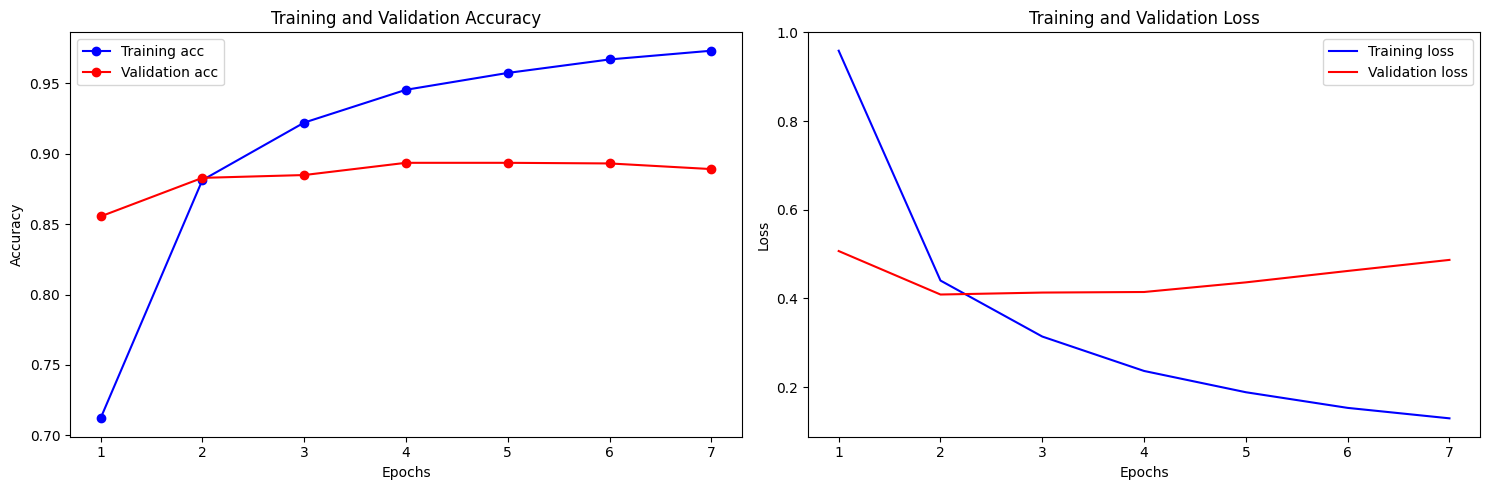

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(epochs, train_acc, 'bo-', label='Training acc')
axes[0].plot(epochs, val_acc, 'ro-', label='Validation acc')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, train_loss, 'b', label='Training loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


##### Mô hình BiLSTM

In [ ]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text + test_text + val_text)
X_train = tokenizer.texts_to_sequences(train_text)
X_test = tokenizer.texts_to_sequences(test_text)
X_val = tokenizer.texts_to_sequences(val_text)

vocab_size = len(tokenizer.word_index) + 1
maxlen = max(len(x) for x in X_train)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

le = LabelEncoder()
y_train = le.fit_transform(train_label)
y_test = le.transform(test_label)
y_val = le.transform(val_label)


In [ ]:
X_train

array([[  98,  292,  881, ...,    0,    0,    0],
       [1187,  728,   16, ...,    0,    0,    0],
       [ 161,  544,  243, ...,    0,    0,    0],
       ...,
       [ 327,  240,  334, ...,    0,    0,    0],
       [ 851, 3135,  162, ...,    0,    0,    0],
       [3253,  835, 1806, ...,    0,    0,    0]], dtype=int32)

In [ ]:

model = models.Sequential()
model.add(layers.Embedding(vocab_size, 256, input_length=maxlen))
model.add(layers.Conv1D(512, 5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

y_pred = model.predict(X_test).argmax(axis=-1)
print("Bi-LSTM Classification Report:")
print(classification_report(y_test, y_pred, digits=4, target_names=le.classes_))


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5603 - loss: 1.1935 - val_accuracy: 0.8679 - val_loss: 0.4219
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9141 - loss: 0.2931 - val_accuracy: 0.9051 - val_loss: 0.3096
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9558 - loss: 0.1545 - val_accuracy: 0.9004 - val_loss: 0.3224
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9744 - loss: 0.0898 - val_accuracy: 0.9029 - val_loss: 0.3486
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9823 - loss: 0.0647 - val_accuracy: 0.9018 - val_loss: 0.3752
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9863 - loss: 0.0456 - val_accuracy: 0.9000 - val_loss: 0.3927
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9898 - loss: 0.0374 - val_accuracy: 0.8918 - val_loss: 0.4684
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Bi-LSTM Classification Report:
              precision  

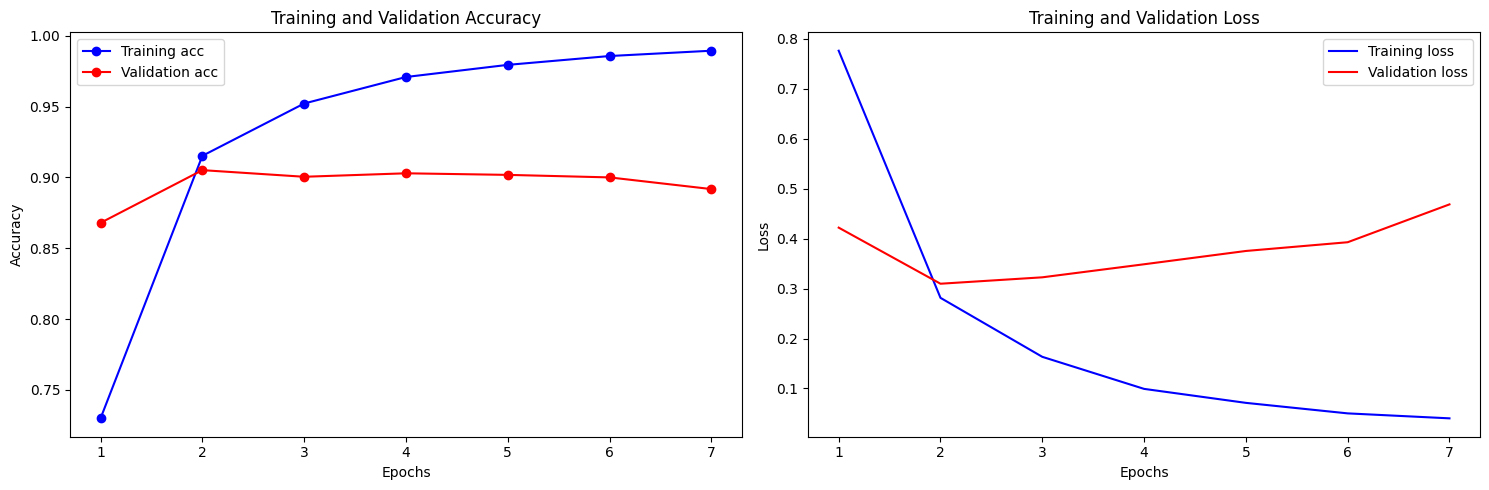

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(epochs, train_acc, 'bo-', label='Training acc')
axes[0].plot(epochs, val_acc, 'ro-', label='Validation acc')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, train_loss, 'b', label='Training loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install py_vncorenlp transformers torch accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


######  Phobert

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=len(train_df['label'].unique()))

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

train_encodings = tokenize_function(train_df['clean_text'].tolist())
val_encodings = tokenize_function(val_df['clean_text'].tolist())
test_encodings = tokenize_function(test_df['clean_text'].tolist())

train_labels = le.transform(train_df['label'])
val_labels = le.transform(val_df['label'])
test_labels = le.transform(test_df['label'])
import torch
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.02,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=-1)

print("BERT Classification Report:")
print(classification_report(test_labels, y_pred, digits=4, target_names=le.classes_))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.267800,0.194438
2,0.151200,0.249787
3,0.100100,0.263784
4,0.042500,0.285483
5,0.022200,0.324744
6,0.018500,0.368462
7,0.012300,0.382535
8,0.005200,0.379543
9,0.001900,0.420755
10,0.000000,0.407104


BERT Classification Report:
              precision    recall  f1-score   support

     doisong     0.8305    0.8288    0.8296       473
     giaoduc     0.9520    0.9655    0.9587       637
     khoahoc     0.9359    0.9076    0.9215       595
      kinhte     0.9272    0.9250    0.9261       867
     suckhoe     0.9715    0.9776    0.9745      1917
     thegioi     0.9575    0.9624    0.9599      1966
     thethao     0.9914    0.9945    0.9929      1626
      thoisu     0.9372    0.9236    0.9303      1034

    accuracy                         0.9530      9115
   macro avg     0.9379    0.9356    0.9367      9115
weighted avg     0.9529    0.9530    0.9530      9115

